# Tutorial 8: Workflow Example

This tutorial demonstrates an example workflow from timeseries extraction to CAPs visualization.

In [4]:
# Download packages
try:
    import neurocaps
except:
    !pip install neurocaps[windows,demo]

# Set headless display for google colab
import os, sys

if "google.colab" in sys.modules:
    os.environ["DISPLAY"] = ":0.0"
    !apt-get install -y xvfb
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &
    !Xvfb :0 -screen 0 1024x768x24 &> /dev/null &


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
import os

demo_dir = "neurocaps_demo"
os.makedirs(demo_dir, exist_ok=True)

The code below fetches two subjects from an [OpenNeuro dataset](https://openneuro.org/datasets/ds005381/versions/1.0.0)
preprocessed with [fMRIPrep](https://fmriprep.org/en/stable/). Downloading data from OpenNeuro requires
``pip install openneuro-py ipywidgets`` or ``pip install neurocaps[demo]``.

In [ ]:
# [Dataset] doi: doi:10.18112/openneuro.ds005381.v1.0.0
from openneuro import download

# Include the run-1 and run-2 data from two subjects
include = [
    "dataset_description.json",
    "sub-0004/ses-2/func/*run-[12]*events*",
    "derivatives/fmriprep/sub-0004/fmriprep/sub-0004/ses-2/func/*run-[12]*confounds_timeseries*",
    "derivatives/fmriprep/sub-0004/fmriprep/sub-0004/ses-2/func/*run-[12]_space-MNI152NLin*preproc_bold*",
    "sub-0006/ses-2/func/*run-[12]*events*",
    "derivatives/fmriprep/sub-0006/fmriprep/sub-0006/ses-2/func/*run-[12]*confounds_timeseries*",
    "derivatives/fmriprep/sub-0006/fmriprep/sub-0006/ses-2/func/*run-[12]_space-MNI152NLin*preproc_bold*",
]

download(
    dataset="ds005381",
    include=include,
    target_dir=demo_dir,
    verify_hash=False,
)


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds005381 …


KeyboardInterrupt: 

The first level of the pipeline directory must also have a dataset_description.json file for querying purposes.


In [6]:
import json

desc = {
    "Name": "fMRIPrep - fMRI PREProcessing workflow",
    "BIDSVersion": "1.0.0",
    "DatasetType": "derivative",
    "GeneratedBy": [
        {"Name": "fMRIPrep", "Version": "20.2.0", "CodeURL": "https://github.com/nipreps/fmriprep"}
    ],
}

with open(
    "neurocaps_demo/derivatives/fmriprep/dataset_description.json", "w", encoding="utf-8"
) as f:
    json.dump(desc, f)

In [7]:
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.utils import fetch_preset_parcel_approach

# List of fMRIPrep-derived confounds for nuisance regression
confound_names = [
    "cosine*",
    "trans_x",
    "trans_x_derivative1",
    "trans_y",
    "trans_y_derivative1",
    "trans_z",
    "trans_z_derivative1",
    "rot_x",
    "rot_x_derivative1",
    "rot_y",
    "rot_y_derivative1",
    "rot_z",
    "rot_z_derivative1",
    "a_comp_cor_00",
    "a_comp_cor_01",
    "a_comp_cor_02",
    "a_comp_cor_03",
    "a_comp_cor_04",
    "global_signal",
    "global_signal_derivative1",
]

# Initialize extractor with signal cleaning parameters
extractor = TimeseriesExtractor(
    space="MNI152NLin6Asym",
    parcel_approach=fetch_preset_parcel_approach("4S", n_nodes=456),
    standardize=True,
    confound_names=confound_names,
    fd_threshold={
        "threshold": 0.50,
        "outlier_percentage": 0.30,
    },
)

# Extract BOLD data from preprocessed fMRIPrep data
# which should be located in the "derivatives" folder
# within the BIDS root directory
# The extracted timeseries data is automatically stored
# Session 2 is the only session available, so `session`
# does not need to be specified
extractor.get_bold(
    bids_dir=demo_dir,
    task="DET",
    condition="late",
    condition_tr_shift=4,
    tr=2,
    verbose=False,
).timeseries_to_pickle(demo_dir, "timeseries.pkl")

2025-07-08 08:36:47,921 neurocaps.extraction._internals.confounds [INFO] Confound regressors to be used if available: cosine*, trans_x, trans_x_derivative1, trans_y, trans_y_derivative1, trans_z, trans_z_derivative1, rot_x, rot_x_derivative1, rot_y, rot_y_derivative1, rot_z, rot_z_derivative1, a_comp_cor_00, a_comp_cor_01, a_comp_cor_02, a_comp_cor_03, a_comp_cor_04, global_signal, global_signal_derivative1.
2025-07-08 08:36:49,605 neurocaps.extraction.timeseries_extractor [INFO] BIDS Layout: ...mples\notebooks\neurocaps_demo | Subjects: 2 | Sessions: 2 | Runs: 4


In [8]:
# Retrieve the dataframe containing QC information for each subject
# to use for downstream statistical analyses
qc_df = extractor.report_qc()
print(qc_df)

  Subject_ID    Run   Mean_FD    Std_FD  Frames_Scrubbed  Frames_Interpolated  \
0       0004  run-1  0.132008  0.142542                1                    0   
1       0004  run-2  0.103799  0.055793                0                    0   
2       0006  run-1  0.153677  0.099153                0                    0   
3       0006  run-2  0.152483  0.078657                0                    0   

   Mean_High_Motion_Length  Std_High_Motion_Length  N_Dummy_Scans  
0                      1.0                     0.0            NaN  
1                      0.0                     0.0            NaN  
2                      0.0                     0.0            NaN  
3                      0.0                     0.0            NaN  


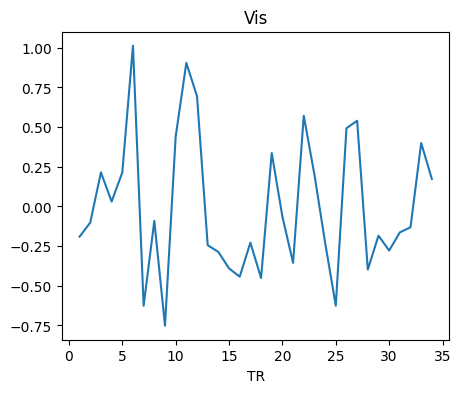

In [9]:
# Visualize BOLD Data
extractor.visualize_bold(subj_id="0004", run=1, region="Vis", figsize=(5, 4))

2025-07-08 08:37:12,959 neurocaps.analysis.cap._internals.cluster [INFO] No groups specified. Using default group 'All Subjects' containing all subject IDs from `subject_timeseries`. The `groups` dictionary will remain fixed unless the `CAP` class is re-initialized or `clear_groups()` is used.
2025-07-08 08:37:13,886 neurocaps.analysis.cap._internals.cluster [INFO] [GROUP: All Subjects | METHOD: variance_ratio] Optimal cluster size is 2.


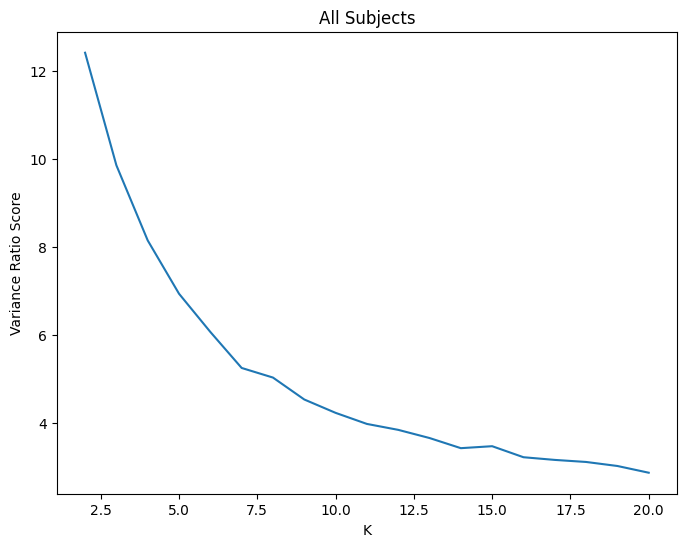

In [10]:
from neurocaps.analysis import CAP

# Initialize CAP class
cap_analysis = CAP(parcel_approach=extractor.parcel_approach)

# Identify the optimal number of CAPs (clusters)
# using the variance_ratio method to test 2-20
# The optimal number of CAPs is automatically stored
cap_analysis.get_caps(
    subject_timeseries=extractor.subject_timeseries,
    n_clusters=range(2, 21),
    standardize=True,
    cluster_selection_method="variance_ratio",
    max_iter=500,
    n_init=10,
    random_state=0,
    show_figs=True,
)

In [11]:
# Calculate temporal fraction and persistence of each CAP for all subjects
output = cap_analysis.calculate_metrics(
    extractor.subject_timeseries, metrics=["temporal_fraction"]
)
print(output["temporal_fraction"])

  Subject_ID         Group    Run     CAP-1     CAP-2
0       0004  All Subjects  run-1  0.411765  0.588235
1       0004  All Subjects  run-2  0.500000  0.500000
2       0006  All Subjects  run-1  0.486486  0.513514
3       0006  All Subjects  run-2  0.516129  0.483871


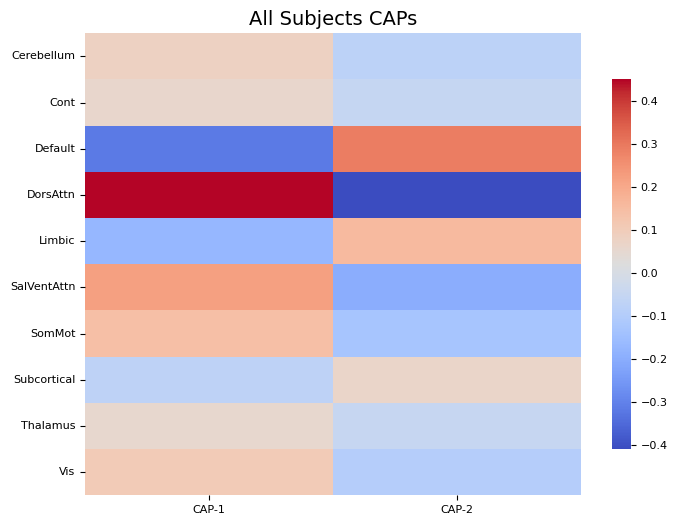

In [12]:
cap_analysis.caps2plot(plot_options="heatmap")

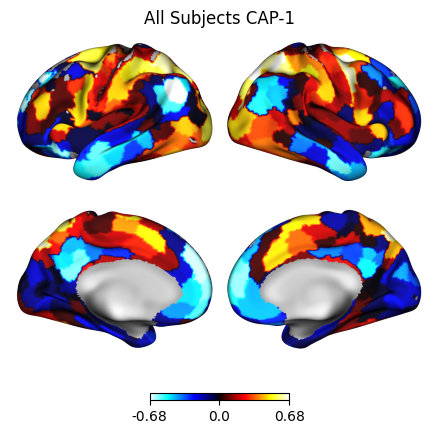

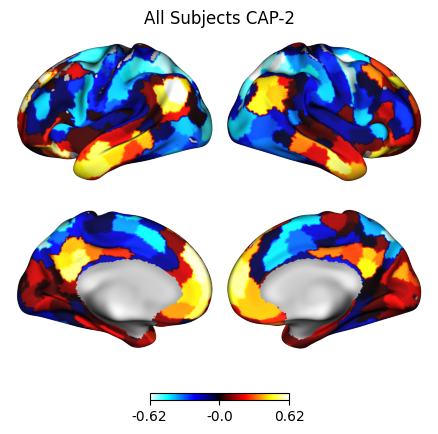

In [ ]:
# Project CAPs onto surface plots
# and generate cosine similarity network alignment of CAPs

radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.9],
    "tickvals": [0.1, "", 0.3, "", 0.5, "", 0.7, "", 0.9],
}

color_discrete_map = {
    "High Amplitude": "rgba(255, 165, 0, 0.75)",
    "Low Amplitude": "black",
}

cap_analysis.caps2surf().caps2radar(radialaxis=radialaxis, color_discrete_map=color_discrete_map)